# IMPORT NECESSARY PACKAGES

In [24]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

import tensorflow
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout

# LOAD DATA

In [2]:
fpt = pd.read_csv('FPT.csv', parse_dates=True, index_col='Date/Time')
msn = pd.read_csv('MSN.csv', parse_dates=True, index_col='Date/Time')
pnj = pd.read_csv('PNJ.csv', parse_dates=True, index_col='Date/Time')
vic = pd.read_csv('VIC.csv', parse_dates=True, index_col='Date/Time')

stocks = {'fpt':fpt, "msn":msn, 'pnj':pnj, 'vic':vic}

# A FIRST GLANCE AT THE DATASET
Each stock csv file is of the same structure. I choose FPT only for demonstration

In [3]:
fpt.head(3)

,Ticker,Open,High,Low,Close,Volume,Open Interest
Date/Time,,,,,,,
2018-12-25 09:15:00,FPT,30.89,30.89,30.89,30.89,35410,0
2018-12-25 09:16:00,FPT,30.81,30.81,30.81,30.81,190,0
2018-12-25 09:17:00,FPT,30.74,30.81,30.74,30.74,1120,0


In [4]:
fpt.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97406 entries, 2018-12-25 09:15:00 to 2020-12-22 14:46:00
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ticker         97406 non-null  object 
 1   Open           97406 non-null  float64
 2   High           97406 non-null  float64
 3   Low            97406 non-null  float64
 4   Close          97406 non-null  float64
 5   Volume         97406 non-null  int64  
 6   Open Interest  97406 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 5.9+ MB


In [5]:
fpt.describe()

,Open,High,Low,Close,Volume,Open Interest
count,97406.000000,97406.000000,97406.000000,97406.000000,9.740600e+04,97406.0
mean,45.071630,45.090138,45.051430,45.071631,8.044173e+03,0.0
std,6.359803,6.364950,6.354245,6.359799,1.753203e+04,0.0
min,30.250000,30.250000,30.220000,30.250000,1.000000e+01,0.0
25%,39.740000,39.740000,39.700000,39.740000,7.500000e+02,0.0
50%,46.950000,46.950000,46.950000,46.950000,2.960000e+03,0.0
75%,49.200000,49.250000,49.170000,49.200000,8.960000e+03,0.0
max,58.400000,58.500000,58.400000,58.400000,1.255930e+06,0.0


### Check Open Interest column and whether duplicate rows appear or not

In [6]:
for name, stock in stocks.items():
    print(name.upper(), \
          'open interest sum:', stock['Open Interest'].sum(), \
            'duplicate data:', stock.duplicated().sum())

FPT open interest sum: 0 duplicate data: 13811
MSN open interest sum: 0 duplicate data: 27729
PNJ open interest sum: 0 duplicate data: 21684
VIC open interest sum: 0 duplicate data: 25645


### Time Range

In [7]:
for name, stock in stocks.items():
    print(name.upper(), \
          'from', stock.index.min(), \
            'to', stock.index.max())

FPT from 2018-12-25 09:15:00 to 2020-12-22 14:46:00
MSN from 2017-12-25 09:15:00 to 2020-12-22 14:46:00
PNJ from 2018-02-28 09:15:00 to 2020-12-22 14:46:00
VIC from 2018-10-17 09:39:00 to 2020-12-22 14:46:00


### **Insight 1**
- Open interest equals 0 for the whole period, hence we can ignore this feature for now
- No null/duplicate data appeared

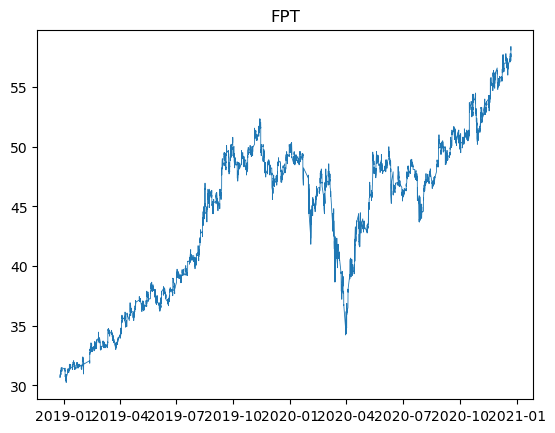

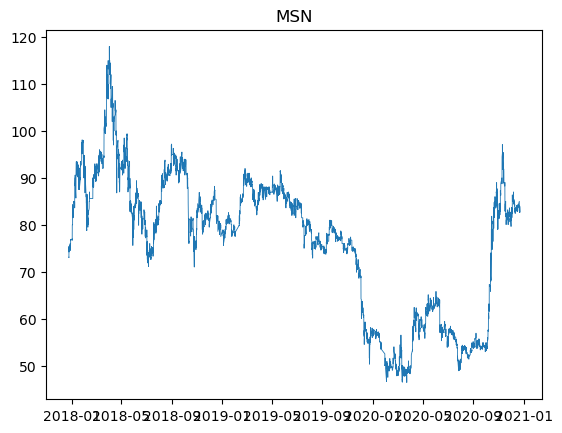

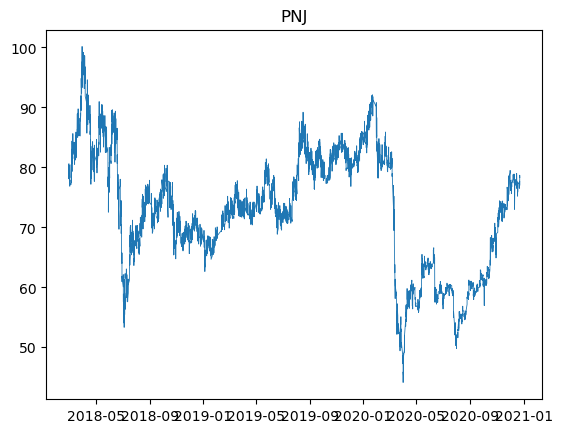

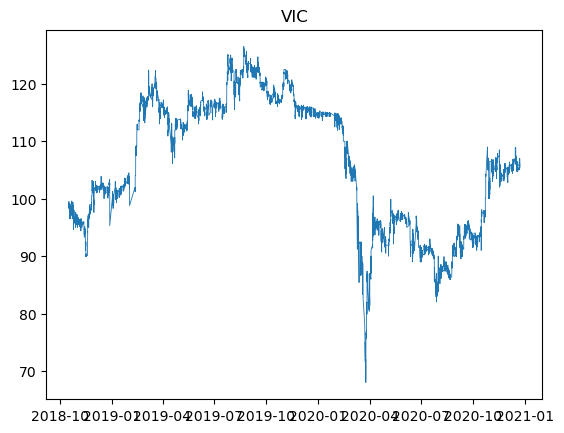

In [8]:
for name,stock in stocks.items():

    plt.plot(stock.index, stock['Close'], linewidth=0.6)
    plt.title(name.upper())
    plt.xticks()
    plt.show()

### **Insight 2**: 

- From stock's characteristics and these above plots, we see that all 4 time series have no seasonality, no cyclicality, no pattern and have no trend apart from FPT stock
- Since tradional time series such as average method, naive, AR or MA models only capture trend or seasonality and stock data contains huge amount of randomness

That is why I will choose machine learning models instead of tradional time series models

In [9]:
# NOT EQUAL INTERVAL

# Modeling

### Stock Price Prediction by day

In [10]:
# dự báo biến động giá theo ngày
fpt_by_day = fpt.groupby(fpt.index.strftime('%Y-%m-%d')).agg(\
    {'Open': 'first', 'High': 'max',\
    'Low': 'min', 'Close': 'last',\
    'Volume': 'sum'})
fpt_by_day

,Open,High,Low,Close,Volume
Date/Time,,,,,
2018-12-25,30.89,30.89,30.59,30.66,84960
2018-12-26,31.04,31.22,30.89,30.89,333590
2018-12-27,31.41,31.52,31.19,31.19,454860
2018-12-28,31.34,31.49,31.19,31.49,387170
2019-01-02,31.19,31.45,30.70,30.74,459120
...,...,...,...,...,...
2020-12-16,57.20,57.50,57.00,57.10,1995530
2020-12-17,56.90,57.00,56.00,56.50,3594500
2020-12-18,56.50,57.00,56.50,56.90,1532820


In [11]:
# try predict with only Close column
fpt_close = fpt_by_day['Close']
fpt_close.reset_index(drop=True, inplace=True)
fpt_close = pd.DataFrame(fpt_close)

In [12]:
# train test split
train = fpt_close[:489]
test = fpt_close[489:]
print(train.shape, test.shape)

(480, 1) (15, 1) (4, 1)


In [13]:
# scale
scaler = MinMaxScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [19]:
length = 10 # look back window
batch_size = 32 
n_features = 1
train_generator = TimeseriesGenerator(train_scaled, train_scaled, \
                                length = length, batch_size = batch_size)

In [25]:
train_univariate = tensorflow.data.Dataset.from_tensor_slices((train_scaled, train_scaled))
train_univariate = train_univariate.cache().batch(batch_size).repeat()

val_univariate = tensorflow.data.Dataset.from_tensor_slices((test_scaled, test_scaled))
val_univariate = val_univariate.batch(batch_size).repeat()

In [26]:
train_univariate

<_RepeatDataset element_spec=(TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>